In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import networkx as nx
from scipy.sparse import csr_matrix
import matplotlib
import warnings
import matplotlib.pyplot as plt
import collections
import scipy
import statistics as stats

warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)

# Cooffending network

In [2]:
df = pd.read_csv("release_networks_homework_data/Cooffending/Cooffending.csv")
df.CrimeDate = pd.to_datetime(df.CrimeDate)
df["NOffenders"] = df.NumberYouthOffenders + df.NumberAdultOffenders
n_cases_raw = len(df)
df = df.drop_duplicates()
# There are five people who are listed as both M and F, just drop one of them
df = df.drop_duplicates(subset=["OffenderIdentifier", "CrimeIdentifier"])
n_cases = len(df)
n_criminals = len(df.OffenderIdentifier.unique())
n_crimes = len(df.CrimeIdentifier.unique())
df.head()

,OffenderIdentifier,OffenderGender,CrimeIdentifier,CrimeType1,CrimeType2,CrimeType3,CrimeType4,Municipality,CrimeLocation,NumberYouthOffenders,NumberAdultOffenders,CrimeDate,CrimeYear,NOffenders
0,1,F,1085034,3530.0,NaN,NaN,NaN,58227,2.0,0,1,2005-12-17,2005,1
1,2,F,1431379,1430.0,NaN,NaN,NaN,94068,5.0,0,1,2008-04-23,2008,1
2,4,M,167174,1430.0,21702.0,NaN,NaN,49058,2.0,0,1,2008-03-06,2008,1
3,5,M,1179096,1420.0,NaN,NaN,NaN,65005,71.0,0,1,2008-08-21,2008,1
4,17,M,1270690,1625.0,NaN,NaN,NaN,23027,NaN,0,3,2003-04-30,2003,3


# Part (a)

In [3]:
print("Number of cases after removing duplicates: {}".format(n_cases))

Number of cases after removing duplicates: 1279987


# Part (b)

In [4]:
print("Number of unique criminals: {}".format(n_criminals))

Number of unique criminals: 539593


# Part (c)

In [5]:
print("Number of unique crimes: {}".format(n_crimes))

Number of unique crimes: 1164836


In [6]:
df.drop_duplicates("CrimeIdentifier").groupby(['CrimeYear']).agg(['count'])[["CrimeIdentifier"]]

,CrimeIdentifier
,count
CrimeYear,
2003,110556
2004,121374
2005,172664
2006,185840
2007,196151
2008,199288
2009,178959
2010,4


Thus, 2008 has the most crimes, with 199288 crimes.



# Part (d)

**Question 1**

In [7]:
df.drop_duplicates("CrimeIdentifier") \
    .sort_values("NOffenders", ascending=False)[["CrimeIdentifier", "NOffenders", "Municipality"]] \
    .head()

,CrimeIdentifier,NOffenders,Municipality
43313,27849,156,66023
43470,876159,102,12072
737402,445040,97,66023
980905,36209,93,36033
688249,539385,62,66023


Thus, Crime 27849 had the most offenders with 156 offenders in municipality 66023

**Question 2**

In [8]:
df['OffenderIdentifier'].value_counts(sort=True).head()

300728    456
440431    358
253577    357
120976    350
373749    275
Name: OffenderIdentifier, dtype: int64

Thus, offender 300728 committed the most crimes with 456 crimes.

# Part (e)

In [9]:
# Remap to consecutive identifiers
OffenderIdentifier_dict = {OffenderIdentifier: i for i, OffenderIdentifier in enumerate(df.OffenderIdentifier.unique())}
CrimeIdentifier_dict = {CrimeIdentifier: i for i, CrimeIdentifier in enumerate(df.CrimeIdentifier.unique())}

# .replace has a lot of overhead
df.OffenderIdentifier = df.OffenderIdentifier.map(OffenderIdentifier_dict.get)
df.CrimeIdentifier = df.CrimeIdentifier.map(CrimeIdentifier_dict.get)

assert not df.OffenderIdentifier.isnull().any() and not df.CrimeIdentifier.isnull().any()
assert df.CrimeIdentifier.max() == df.CrimeIdentifier.nunique() - 1
assert df.OffenderIdentifier.max() == df.OffenderIdentifier.nunique() - 1

In [10]:
# Build matrix
row = df.OffenderIdentifier
col = df.CrimeIdentifier
vals = np.ones(len(row))

# Sparse representation
crime_matrix = csr_matrix((vals, (row, col)), shape=(row.max() + 1, col.max() + 1))

In [11]:
cooffend_matrix = crime_matrix @ crime_matrix.T

# Save an unmodified copy for later
cooffend_matrix_raw = cooffend_matrix.copy()

# convert to (binary) adj. matrix
# Could use the full cooffending matrix for project
cooffend_matrix[cooffend_matrix > 0] = 1
cooffend_matrix.setdiag(0)
cooffend_matrix.eliminate_zeros() # To avoid self loops since setdiag(0) does not itself change the sparsity pattern

In [12]:
g = nx.from_scipy_sparse_matrix(cooffend_matrix)

In [13]:
print("Number of nodes: {}".format(g.number_of_nodes()))

Number of nodes: 539593


In [14]:
print("Number of isolated nodes: {}".format(len(list(nx.isolates(g)))))

Number of isolated nodes: 418434


In [15]:
print("Number of edges: {}".format(g.number_of_edges()))

Number of edges: 178413


# Part (f)

In [16]:
g_removed = g.copy()
g_removed.remove_nodes_from(list(nx.isolates(g_removed)))

In [17]:
degree_list = sorted([d for n, d in g_removed.degree()], reverse=True)
print("Mean of node degrees: {}".format(np.mean(degree_list)))

Mean of node degrees: 2.945105192350548


In [18]:
print("Number of nodes with degree >= 100: {}".format(np.sum(np.array(degree_list) >= 100)))

Number of nodes with degree >= 100: 265


In [19]:
component_list = sorted(nx.connected_components(g_removed), key=len, reverse=True)
print("Number of connected components: {}".format(len(component_list)))

Number of connected components: 36098


# Part (g)

In [20]:
#plt.hist(g_removed.degree())

# Part (h)

In [21]:
largest_component = g_removed.subgraph(component_list[0])
print("Number of nodes in largest component: {}".format(largest_component.number_of_nodes()))

Number of nodes in largest component: 19924


# Part (i)

In [22]:
# Separate matrices for repeating co-offenders vs non-repeating co-offenders
cooffend_matrix_repeat = cooffend_matrix_raw.copy()
cooffend_matrix_no_repeat = cooffend_matrix_raw.copy()

# Repeating co-offenders: edge strength >= 2
cooffend_matrix_repeat.data[np.where(cooffend_matrix_repeat.data<2)[0]]=0
cooffend_matrix_repeat[cooffend_matrix_repeat > 0] = 1
cooffend_matrix_repeat.setdiag(0)
cooffend_matrix_repeat.eliminate_zeros() # To avoid self loops since setdiag(0) does not itself change the sparsity pattern

# Non-repeating co-offenders: edge strength = 1
cooffend_matrix_no_repeat.data[np.where(cooffend_matrix_no_repeat.data!=1)[0]]=0
cooffend_matrix_no_repeat[cooffend_matrix_no_repeat > 0] = 1
cooffend_matrix_no_repeat.setdiag(0)
cooffend_matrix_no_repeat.eliminate_zeros() # To avoid self loops since setdiag(0) does not itself change the sparsity pattern

In [23]:
g_r = nx.from_scipy_sparse_matrix(cooffend_matrix_repeat)
g_nr = nx.from_scipy_sparse_matrix(cooffend_matrix_no_repeat)

g_r.remove_nodes_from(list(nx.isolates(g_r)))
g_nr.remove_nodes_from(list(nx.isolates(g_nr)))

**Question 1**

In [24]:
print("""
Number of nodes in G_r: {}
Number of nodes in G_nr: {}
""".format(g_r.number_of_nodes(), g_nr.number_of_nodes()))


Number of nodes in G_r: 17764
Number of nodes in G_nr: 113519



**Question 2**

In [25]:
print("""
Number of edges in G_r: {}
Number of edges in G_nr: {}
""".format(g_r.number_of_edges(), g_nr.number_of_edges()))


Number of edges in G_r: 15448
Number of edges in G_nr: 162965



# Part (j)

In [26]:
g_r_component_list = sorted(nx.connected_components(g_r), key=len, reverse=True)
g_nr_component_list = sorted(nx.connected_components(g_nr), key=len, reverse=True)
print("""
Number of components in G_r: {}
Number of components in G_nr: {}
""".format(len(g_r_component_list), len(g_nr_component_list)))
print("""
Average component size for G_r: {}
Average component size for G_nr: {}
""".format(np.mean(list(map(len, g_r_component_list))), np.mean(list(map(len, g_nr_component_list)))))


Number of components in G_r: 6463
Number of components in G_nr: 35596


Average component size for G_r: 2.7485687761101656
Average component size for G_nr: 3.189094280256209



# Part (k)

In [27]:
g_r_largest_component = g_r.subgraph(g_r_component_list[0])
g_nr_largest_component = g_nr.subgraph(g_nr_component_list[0])

In [28]:
print("""
Fraction of nodes in largest component of G_r: {}
Fraction of nodes in largest component of G_nr: {}
""".format(
    g_r_largest_component.number_of_nodes()/float(g_r.number_of_nodes()), 
    g_nr_largest_component.number_of_nodes()/float(g_nr.number_of_nodes())))


Fraction of nodes in largest component of G_r: 0.0037153794190497636
Fraction of nodes in largest component of G_nr: 0.10646675886855944



# Part (l)

In [29]:
print("""
Density of largest component of G: {}
Density of largest component of G_r: {}
Density of largest component of G_nr: {}
""".format(*map(nx.density, [largest_component, g_r_largest_component, g_nr_largest_component])))


Density of largest component of G: 0.0003556454848657796
Density of largest component of G_r: 0.04568764568764569
Density of largest component of G_nr: 0.0007231308979893168



# Part (m)

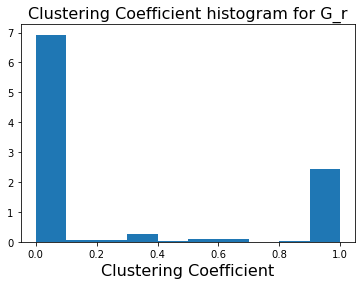

In [49]:
plt.hist(nx.clustering(g_r).values(), bins=10, density=True)
plt.xlabel('Clustering Coefficient', size=16)
plt.title('Clustering Coefficient histogram for G_r', size=16)
plt.savefig('images/clustering coefficient for G_r.png')
plt.show()

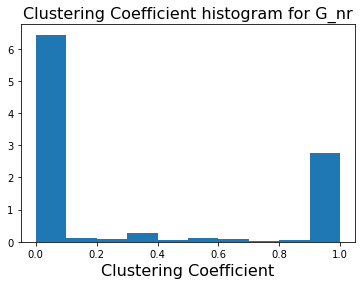

In [50]:
plt.hist(nx.clustering(g_nr).values(), bins=10, density=True)
plt.xlabel('Clustering Coefficient', size=16)
plt.title('Clustering Coefficient histogram for G_nr', size=16)
plt.savefig('images/clustering coefficient for G_nr.png')
plt.show()

# Part (n)

In [ ]:
nx.draw(g_nr)